#구글 드라이브 마운트하여 구글 드라이브 사용

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import os
import cv2

def count_images_in_folder(folder_path):
    # 지정된 폴더에서 이미지 파일 목록 가져오기
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]

    # 이미지 파일의 개수 출력
    print(f"폴더 '{folder_path}'에는 총 {len(image_files)}개의 이미지 파일이 있습니다.")

if __name__ == "__main__":
    folder_path = "/content/drive/MyDrive/느티나무2/train/disease"
    count_images_in_folder(folder_path)

폴더 '/content/drive/MyDrive/느티나무2/train/disease'에는 총 378개의 이미지 파일이 있습니다.


#시각화

In [ ]:
from google.colab import drive
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import numpy as np

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

import matplotlib.font_manager as fm


import matplotlib.pyplot as plt

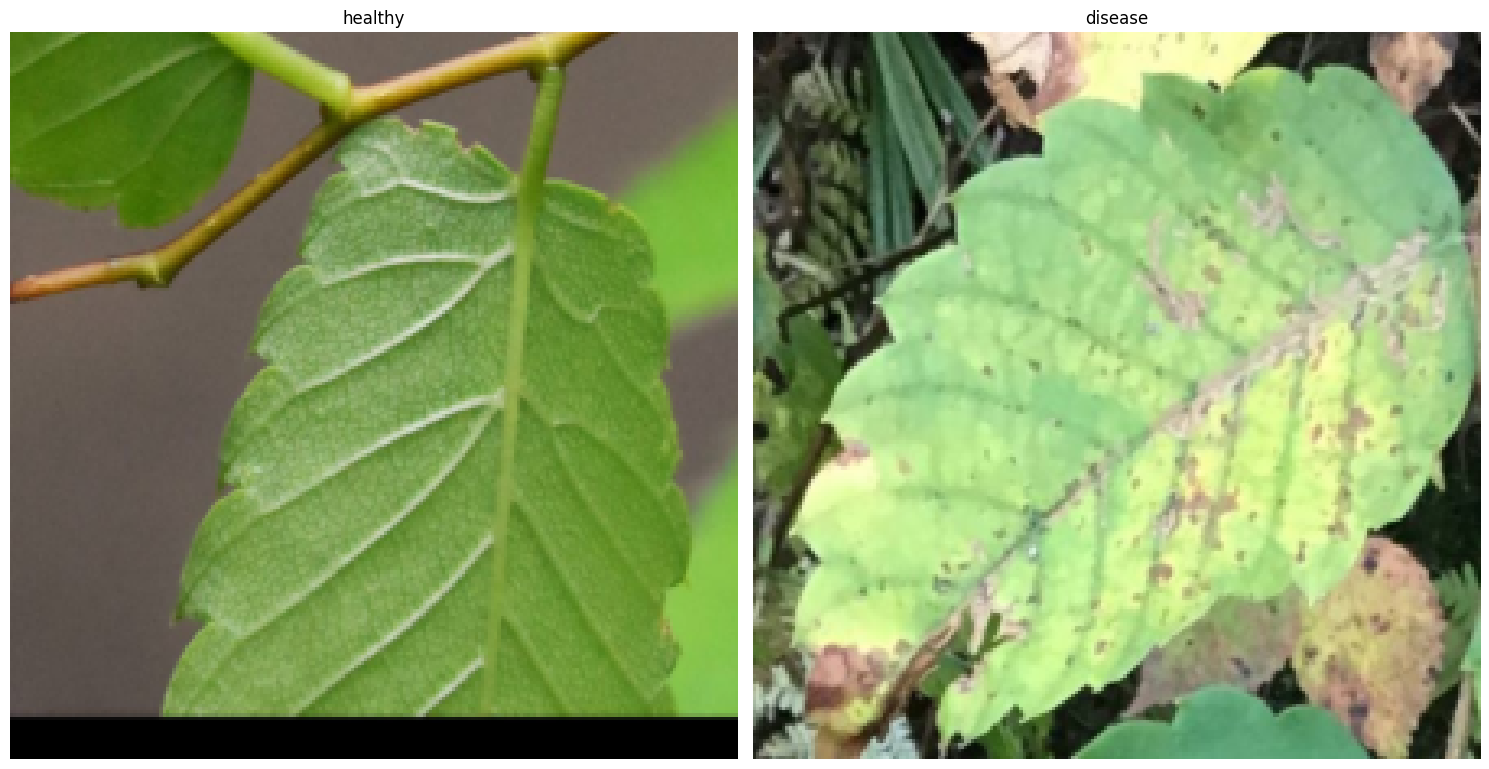

In [ ]:
# 데이터셋 경로 설정
data_dir = '/content/drive/MyDrive/느티나무 질병 데이터셋/train'

# 클래스 목록 설정
classes = os.listdir(data_dir)

# 데이터 변환 설정
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 이미지 크기 조절
    transforms.ToTensor(),  # 파이토치 텐서로 변환
])

class CustomDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.images = []
        self.labels = []
        for label, class_name in enumerate(classes):
            class_dir = os.path.join(data_dir, class_name)
            image_name = os.listdir(class_dir)[0]  # 각 클래스에서 첫 번째 이미지의 이름을 가져옴
            image_path = os.path.join(class_dir, image_name)
            self.images.append(image_path)
            self.labels.append(label)  # 클래스의 인덱스를 라벨로 사용

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        image = Image.open(image_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# 데이터셋 생성
dataset = CustomDataset(data_dir, transform)

# 클래스별 예시 이미지 시각화
fig, axs = plt.subplots(1, 2, figsize=(15, 15))

names =["healthy", "disease"]

for i, ax in enumerate(axs.flat):
    img, label = dataset[i]
    ax.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    ax.set_title(names[label], fontsize=12)  # 클래스 이름을 한글로 표시
    ax.axis('off')

plt.tight_layout()
plt.show()

#데이터 전처리

In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn # 인공 신경망 모델들 모아놓은 모듈
import torch.nn.functional as F #그중 자주 쓰이는것들을 F로
from torchvision import transforms, datasets
import cv2
import pandas as pd
import os
from glob import glob
import torchvision.models as models
import sys
import librosa, librosa.display
#from pytorchtools import EarlyStopping
from torch.utils.data import random_split, DataLoader
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split

if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
#DEVICE = torch.device('cpu')
print('Using Pytorch version : ',torch.__version__,' Device : ',DEVICE)

#3. 하이퍼 파라미터
BATCH_SIZE =  64 #한 배치당 64개 이미지데이터
EPOCHS = 100# 전체 데이터 셋을 50번 반복

Using Pytorch version :  2.1.0+cu121  Device :  cuda


In [3]:
train_data_dir= '/content/drive/MyDrive/느티나무 질병 데이터셋/train'
# Create the ImageFolder dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    #transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    # Cutout을 추가
    #transforms.RandomErasing(p=0.3, scale=(0.02, 0.1), ratio=(0.3, 2.3), value=0),
])
dataset = ImageFolder(root=train_data_dir, transform=transform)

#모델

In [ ]:
"""
import torch
import torch.nn as nn
import torchvision.models as models

def model_initialize():
    # Initialize VGG19 model with pre-trained weights
    model = models.vgg16(pretrained=True)
    num_ftrs = model.classifier[-1].in_features

    # Modify the fully connected layer to match the number of classes (e.g., 2)
    model.classifier[6] = nn.Linear(num_ftrs, 2)

    model = model.cuda()
    return model

model = model_initialize()
"""

'\nimport torch\nimport torch.nn as nn\nimport torchvision.models as models\n\ndef model_initialize():\n    # Initialize VGG19 model with pre-trained weights\n    model = models.vgg16(pretrained=True)\n    num_ftrs = model.classifier[-1].in_features\n\n    # Modify the fully connected layer to match the number of classes (e.g., 2)\n    model.classifier[6] = nn.Linear(num_ftrs, 2)\n\n    model = model.cuda()\n    return model\n\nmodel = model_initialize()\n'

In [4]:
import torch
import torch.nn as nn
import torchvision.models as models

def model_initialize():
    # Initialize DenseNet121 model with pre-trained weights
    model = models.densenet201(pretrained=True)

    # Modify the fully connected layer to match the number of classes (e.g., 2)
    num_ftrs = model.classifier.in_features
    model.classifier = nn.Linear(num_ftrs, 2)

    model = model.cuda()
    return model

model = model_initialize()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth
100%|██████████| 77.4M/77.4M [00:03<00:00, 25.7MB/s]


In [5]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import MultiStepLR
from torch.optim.lr_scheduler import LambdaLR

lr = 0.0001
num_ins = [365, 378]

weights = [1 - (x/sum(num_ins)) for x in num_ins]
class_weights = torch.FloatTensor(weights).to(DEVICE)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(),lr=lr)

# Lambda function to adjust learning rate
lr_lambda = lambda EPOCHS: 0.5 ** (EPOCHS // 20)  # Assuming step_size=15 and gamma=0.5

scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)

#scheduler = StepLR(optimizer, step_size=15, gamma=0.5)

"""
momentum = 0.9
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

# MultiStepLR scheduler
milestones = [15, 30, 45]
gamma = 0.5
scheduler = MultiStepLR(optimizer, milestones=milestones, gamma=gamma)
"""

print(model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
#8. 학습
def train(model,train_loader,optimizer, log_interval):
    model.train()
    correct = 0
    train_loss = 0
    for batch_idx,(image,label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        #데이터들 장비에 할당
        optimizer.zero_grad() # device 에 저장된 gradient 제거
        output = model(image) # model로 output을 계산
        loss = criterion(output, label) #loss 계산
        train_loss += loss.item()
        prediction = output.max(1,keepdim=True)[1] # 가장 확률이 높은 class 1개를 가져온다.그리고 인덱스만
        correct += prediction.eq(label.view_as(prediction)).sum().item()# 아웃풋이 배치 사이즈 32개라서.
        loss.backward() # loss 값을 이용해 gradient를 계산
        optimizer.step() # Gradient 값을 이용해 파라미터 업데이트.
    train_loss/=len(train_loader.dataset)
    train_accuracy = 100. * correct / len(train_loader.dataset)
    return train_loss,train_accuracy

In [ ]:
#9. 학습 진행하며, validation 데이터로 모델 성능확인
def evaluate(model,valid_loader):
    model.eval()
    misclassified_images = []
    valid_loss = 0
    correct = 0
    #no_grad : 그래디언트 값 계산 막기.
    with torch.no_grad():
        for image, label in valid_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            valid_loss += criterion(output, label).item()
            prediction = output.max(1,keepdim=True)[1] # 가장 확률이 높은 class 1개를 가져온다.그리고 인덱스만
            correct += prediction.eq(label.view_as(prediction)).sum().item()# 아웃풋이 배치 사이즈 32개라서.
                        # Check for misclassified images
            for i in range(label.size(0)):
                if prediction[i] != label[i]:
                    misclassified_images.append((image[i], prediction[i], label[i]))

            #true.false값을 sum해줌. item
        valid_loss /= len(valid_loader.dataset)
        valid_accuracy = 100. * correct / len(valid_loader.dataset)
        return valid_loss, valid_accuracy, misclassified_images

In [ ]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.6/248.6 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.5 MB/s eta 0:00:00


In [ ]:
!wandb login #2760afae3cddc39355fd83d56a601147e18e1acf

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
import wandb
wandb.init(project='Plant')

# 실행 이름 설정
wandb.run.name = 'DenseNet201 Pretrained O + DataAug(Num O, Jitter, Affine X) + Adam + Lambda_Sch20 + epochs 500'
wandb.run.save()

wandb: Currently logged in as: iuapink0522. Use `wandb login --relogin` to force relogin


wandb: WARNING Calling wandb.run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


True

In [ ]:
args = {
    "learning_rate": lr,
    "epochs": EPOCHS,
    "batch_size": BATCH_SIZE
}
wandb.config.update(args)

In [ ]:
import os
import numpy as np
from sklearn.model_selection import KFold
from copy import deepcopy
# Define the number of folds
num_folds = 5  # You can change this number as needed

# Initialize lists to store results for each fold
all_train_losses = []
all_train_accuracies = []
all_valid_losses = []
all_valid_accuracies = []

best_acc = 0
best_f1 = 0
best_acc_model = None
best_f1_model = None

# Create a KFold object to split your data
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

for fold, (train_indices, valid_indices) in enumerate(kf.split(dataset)):
    train_data = torch.utils.data.Subset(dataset, train_indices)
    valid_data = torch.utils.data.Subset(dataset, valid_indices)

    train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
    validation_loader = DataLoader(valid_data, batch_size=BATCH_SIZE)

    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []

    for Epoch in range(1, EPOCHS+1):
        train_loss, train_accuracy = train(model, train_loader, optimizer, log_interval=31)
        valid_loss, valid_accuracy, _ = evaluate(model, validation_loader)
        wandb.log({"Training loss": train_loss, "Train Acc": train_accuracy, "Val loss": valid_loss, "Val Acc": valid_accuracy})

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_accuracy)

        scheduler.step()

        print("\n[Fold {}][EPOCH:{}]\t Train Loss:{:.4f}\t Train Acc:{:.2f} %  | \tValid Loss:{:.4f} \tValid Acc: {:.2f} %\n".format(fold, Epoch, train_loss, train_accuracy, valid_loss, valid_accuracy))

    all_train_losses.append(train_losses)
    all_train_accuracies.append(train_accuracies)
    all_valid_losses.append(valid_losses)
    all_valid_accuracies.append(valid_accuracies)



In [ ]:
import torch
import torchvision.models as models
import torch.nn as nn

best_model_state = deepcopy(model.state_dict())

# Specify the path where you want to save the model's parameters
save_path = '/content/drive/MyDrive/느티나무 질병 데이터셋/parameter/'

# Save only the model parameters (state_dict)
torch.save(model.state_dict(), save_path + 'DenseNet201 Pretrained O + DataAug(Num O, Jitter, Affine X) + Adam + Lambda_Sch20 + epochs500')

#성능 평가

In [6]:
import torch
import torch.nn as nn
import torchvision.models as models

# 저장한 모델 불러오기
#loaded_model = models.vgg16()
loaded_model = models.densenet201(pretrained=True)
num_ftrs = model.classifier.in_features
loaded_model.classifier = nn.Linear(num_ftrs, 2)

#loaded_model.classifier[-1] = nn.Linear(4096, 2)  # 마지막 층을 이진 분류에 맞게 변경
loaded_model.load_state_dict(torch.load('/content/drive/MyDrive/느티나무 질병 데이터셋/parameter/DenseNet201 Pretrained O + DataAug(Num O, Jitter, Affine X) + Adam + Lambda_Sch20 + epochs500'))

loaded_model.to(DEVICE)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [7]:
test_data_dir = '/content/drive/MyDrive/느티나무 질병 데이터셋/test'
transform_test = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to the same size used in training
    transforms.ToTensor(),  # Convert to a tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize using the same mean and standard deviation as training
])
test_dataset = ImageFolder(root=test_data_dir, transform=transform_test)

test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)

In [8]:
def evaluate2(model,test_loader):
    model.eval()
    misclassified_images = []
    test_loss = 0
    correct = 0
    test_losses=[]
    test_acc=[]
    indexes = [0, 1]

    # 예측과 실제 라벨 리스트 초기화
    all_predictions = []
    all_labels = []

    test_loss = 0
    test_a = 0
    #no_grad : 그래디언트 값 계산 막기.
    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()

            prediction = output.max(1,keepdim=True)[1] # 가장 확률이 높은 class 1개를 가져온다.그리고 인덱스만
            correct += prediction.eq(label.view_as(prediction)).sum().item()# 아웃풋이 배치 사이즈 32개라서.

            all_predictions.extend(prediction.cpu().numpy())
            all_labels.extend(label.cpu().numpy())
            # Check for misclassified images
            for i in range(label.size(0)):
                if prediction[i] != label[i]:
                    misclassified_images.append((image[i], prediction[i], label[i]))

        test_loss /= len(test_loader.dataset)
        test_a = 100. * correct / len(test_loader.dataset)

        return test_loss, test_a, misclassified_images, all_predictions, all_labels

In [9]:
test_loss, test_a, misclassified_images, all_predictions, all_labels = evaluate2(loaded_model, test_loader)

print("test_loss: ", test_loss, "test_acc", test_a)

test_loss:  7.51134429643624e-05 test_acc 100.0


Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000


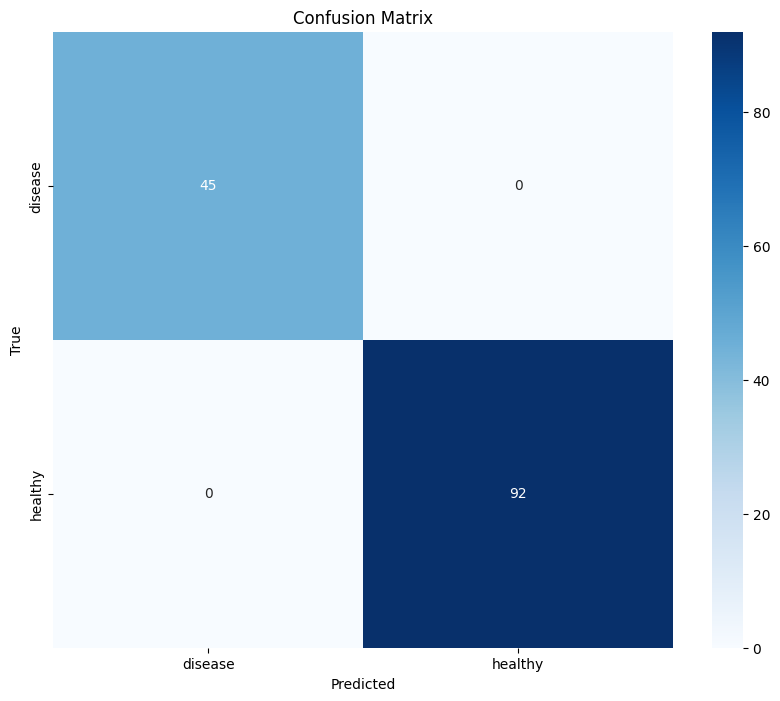

In [10]:
classes = ["disease","healthy"]

import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Confusion matrix 계산
cm = confusion_matrix(all_labels, all_predictions)

# 정확도, 정밀도, 재현율, F1 점수 계산
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')
f1 = f1_score(all_labels, all_predictions, average='weighted')

# 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# 출력
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

plt.show()

In [11]:
len(misclassified_images)

0

In [12]:
import matplotlib.pyplot as plt

for class_index in range(len(classes)):
    # Get misclassified images for the current class
    misclassified_images_class = [(image, predicted_label, true_label) for image, predicted_label, true_label in misclassified_images if true_label == class_index]

    if not misclassified_images_class:
        continue

    # Print class name
    print(f"\nClass {classes[class_index]}:")

    # Display misclassified images for the current class
    num_images = min(2, len(misclassified_images_class))
    fig, axes = plt.subplots(5, num_images, figsize=(15, 4))

    for j, (image, predicted_label, true_label) in enumerate(misclassified_images_class[:num_images]):
        # Reshape the image tensor and convert it to a NumPy array
        image = image.permute(1, 2, 0).cpu().numpy()

        # Display the image with adjusted size
        axes[j].imshow(image)
        axes[j].set_title(f"Pred: {classes[predicted_label % len(classes)]}, True: {classes[true_label]}")
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()